# Capacity Data Cleaning

This notebook reads raw Planet data, creates a single time series averaging a polygon data from 2002-2024

Input:
- Planet data

Output:
- NetCDF file

In [18]:
import sys
gp = '/home/jupyter-gabriel/'
sys.path.append(gp + "projects/suyana")
from scripts.utils.functions import *

In [19]:
from pathlib import Path

import geopandas as gpd
import xarray as xr

In [5]:
def remove_duplicates_and_fill(ds):
    df = ds.to_dataframe().reset_index()

    # Eliminar duplicados basados en 'time' para cada combinación única de 'lon' y 'lat'
    df_unique = (
        df.groupby(["lon", "lat"])
        .apply(lambda group: group.drop_duplicates(subset="time", keep="first"))
        .reset_index(drop=True)
    )

    # Convertir de vuelta a xarray Dataset
    ds_unique = df_unique.set_index(["lon", "lat", "time"]).to_xarray()

    return ds_unique


def empirical_cdf_matching(x, y):
    """
    Performs empirical CDF matching, handling NaN values.

    Args:
      x: The data to be adjusted.
      y: The reference data.

    Returns:
      The adjusted data.
    """

    # Remove NaNs before calculating CDFs
    x_valid = x[~np.isnan(x)]
    y_valid = y[~np.isnan(y)]

    x_cdf = np.sort(x_valid)
    y_cdf = np.sort(y_valid)

    x_indices = np.searchsorted(x_cdf, x, side="right")
    y_quantiles = x_indices / len(x_cdf)  # Quantiles of x in the valid x range
    y_indices = np.floor(y_quantiles * len(y_cdf)).astype(
        int
    )  # Corresponding indices in y

    adjusted_x = np.take(y_cdf, y_indices, mode="clip")

    # Reinsert NaNs in the adjusted data where they were in the original data
    adjusted_x[np.isnan(x)] = np.nan

    return adjusted_x


def clean_data(ds_2002_2011, ds_2012_2024):
    # Remove Duplicates
    ds_2002_2011 = remove_duplicates_and_fill(ds_2002_2011)
    ds_2012_2024 = remove_duplicates_and_fill(ds_2012_2024)

    # Concat
    ds = xr.concat(
        [
            ds_2002_2011,
            ds_2012_2024,
        ],
        dim="time",
    )

    ds["time"] = pd.to_datetime(ds["time"].values)

    ds = ds.reindex(
        time=pd.date_range(
            start=ds["time"].min().values, end=ds["time"].max().values, freq="D"
        )
    )

    # Fill Nans
    ds = ds.where(ds != 65535, np.nan)

    # Average all pixels
    ds = ds.mean(dim=["lat", "lon"])

    # Remove data from 2024-2025 campaign
    ds = ds.sel(time=slice(None, "2024-10-31"))

    return ds


def cdf_matching(ds):
    # Define the periods
    period1_end = "2011-10-03"
    period2_start = "2012-07-24"

    # Split the dataset into two periods
    ds_period1 = ds.sel(time=slice(None, period1_end))
    ds_period2 = ds.sel(time=slice(period2_start, None))

    # Get the week number for each time point
    ds_period1["week"] = ds_period1["time"].dt.isocalendar().week
    ds_period2["week"] = ds_period2["time"].dt.isocalendar().week
    # ds_period1['month'] = ds_period1['time'].dt.month
    # ds_period2['month'] = ds_period2['time'].dt.month

    # Group by week and apply empirical CDF matching
    adjusted_swc = []

    for week in range(1, 53):  # Assuming a year has 52 weeks
        swc_period1_week = ds_period1["swc"].where(
            ds_period1["week"] == week, drop=True
        )
        swc_period2_week = ds_period2["swc"].where(
            ds_period2["week"] == week, drop=True
        )

        if swc_period1_week.isnull().all() or swc_period2_week.isnull().all():
            raise ValueError("Empty week data.")

        # Apply CDF matching
        adjusted_swc_week = empirical_cdf_matching(
            swc_period1_week.values, swc_period2_week.values
        )

        # Create a new DataArray with the adjusted values and the original time coordinates
        adjusted_swc_week_da = xr.DataArray(
            adjusted_swc_week, coords={"time": swc_period1_week.time}, dims=["time"]
        )
        adjusted_swc.append(adjusted_swc_week_da)

    # Concatenate the adjusted values for all weeks
    ds_period1["swc_adjusted"] = xr.concat(adjusted_swc, dim="time")
    ds_period2["swc_adjusted"] = ds_period2["swc"]
    return ds_period1, ds_period2


def fill_empty_window(ds_period1, ds_period2):
    # Define the empty time window
    empty_window_start = "2011-10-04"
    empty_window_end = "2012-07-24"

    # Create a time range for the empty window
    empty_time_range = pd.date_range(empty_window_start, empty_window_end, freq="D")

    # Generate random values for the empty window
    generated_swc = []
    for day in empty_time_range:
        # Get the week number of the current day
        week = day.isocalendar().week

        # Select data for the corresponding week from period 2
        swc_period2_week = ds_period2["swc"].where(
            ds_period2["time"].dt.isocalendar().week == week, drop=True
        )

        # If there's data for that week in period 2, generate random values
        if len(swc_period2_week) > 0:

            # Debug: I need to add a seed value here
            # Fit an empirical distribution to the weekly data
            empirical_dist = np.random.choice(
                swc_period2_week.values, size=1000, replace=True
            )  # Increase size for smoother distribution

            # Debug: I need to add a seed value here
            # Generate a random value from the empirical distribution
            random_value = np.random.choice(empirical_dist)
        else:
            # Handle cases where there's no data for that week (e.g., set to NaN)
            random_value = np.nan

        generated_swc.append(random_value)

    # Create a DataArray for the generated values
    generated_swc_da = xr.DataArray(
        generated_swc, coords={"time": empty_time_range}, dims=["time"]
    )

    generated_swc_ds = generated_swc_da.to_dataset(name="swc_adjusted")

    # Concatenate the generated data with the adjusted period 1 and period 2 data
    ds_adjusted = xr.concat(
        [ds_period1, generated_swc_ds, ds_period2], dim="time"
    ).sortby("time")

    ds_adjusted = ds_adjusted.rename({"swc": "swc_raw"})

    return ds_adjusted

In [22]:
def netcdf_exists(folder, period):
    try:
        id_canton = folder.name.split("_")[1]
    except Exception:
        print(folder)
        raise
    netcdf_file = folder / f"canton_{id_canton}_{period}.nc"
    return netcdf_file.exists()


def both_netcdf_exist(folder):
    return netcdf_exists(folder, period=1) and netcdf_exists(folder, period=2)


def get_single_time_series(id_canton, planet_canton_folder, out_folder=None):

    ds_2002_2011 = xr.open_dataset(planet_canton_folder / f"canton_{id_canton}_1.nc")
    ds_2012_2024 = xr.open_dataset(planet_canton_folder / f"canton_{id_canton}_2.nc")

    # Process data
    ds = clean_data(ds_2002_2011, ds_2012_2024)
    ds_period1, ds_period2 = cdf_matching(ds)
    ds = fill_empty_window(ds_period1, ds_period2)

    # Save
    if out_folder:
        if not out_folder.exists():
            out_folder.mkdir()
        out_file = f"canton_{id_canton}_test.nc"
        ds.to_netcdf(out_folder / out_file)
        print("Saved:", out_folder / out_file)

    return ds


def clean_canton(id_canton, out_folder=None):
    planet_canton_folder = (
        Path("../../../planet/data/capacity_example/processed") / f"canton_{id_canton}"
    )
    if (out_folder / f"canton_{id_canton}.nc").exists():
        print(out_folder / f"canton_{id_canton}.nc", "exists. Skipping.")
        return
    if both_netcdf_exist(planet_canton_folder):
        try:
            get_single_time_series(
                id_canton, planet_canton_folder, out_folder=out_folder
            )
        except ValueError as e:
            print(e, "Continue.")
            pass
    else:
        print("Missing NetCDF files for 2002-2011 and/or 2012-2024. Skipping")
        return

In [ ]:
# Load data
gdf = gpd.read_file("../../../planet/data/AOIs/Capacity Example Polygons.gpkg")
id_canton_list = list(gdf["id_canton"].unique())
out_folder = Path(f"../../data/capacity_example/raw")

for id_canton in id_canton_list:
    print("Canton:", id_canton)
    clean_canton(id_canton, out_folder=out_folder)

In [23]:
planet_canton_folder = Path(gp + 'suyana/drought/swc/raw/canton_43')
out_folder = Path(gp + 'projects/suyana/data/capacity')
id_canton = 43

In [24]:
get_single_time_series(
    id_canton, planet_canton_folder, out_folder=out_folder
)

/tmp/ipykernel_40612/791349913.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.drop_duplicates(subset="time", keep="first"))
/tmp/ipykernel_40612/791349913.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.drop_duplicates(subset="time", keep="first"))


Saved: /home/jupyter-gabriel/projects/suyana/data/capacity/canton_43_test.nc


<xarray.Dataset> Size: 262kB
Dimensions:       (time: 8176)
Coordinates:
  * time          (time) datetime64[ns] 65kB 2002-06-15 ... 2024-10-31
Data variables:
    swc_raw       (time) float64 65kB nan 0.3081 nan 0.2991 ... 0.222 0.1975 nan
    week          (time) float64 65kB 24.0 24.0 25.0 25.0 ... 44.0 44.0 44.0
    swc_adjusted  (time) float64 65kB nan 0.3233 nan 0.3093 ... 0.222 0.1975 nan

In [26]:
ds = xr.open_dataset(gp + 'projects/suyana/data/capacity/canton_43_test.nc')

In [121]:
import os
path = gp + 'suyana/drought/swc/raw/'
files = os.listdir() 

In [30]:
df = ds.to_dataframe().reset_index()

In [31]:
df["day"] = df["time"].dt.dayofyear
df_clim_reproduced = df.groupby("day").agg(climatology = ('swc_adjusted', 'mean')).reset_index()

<Axes: xlabel='day', ylabel='climatology'>

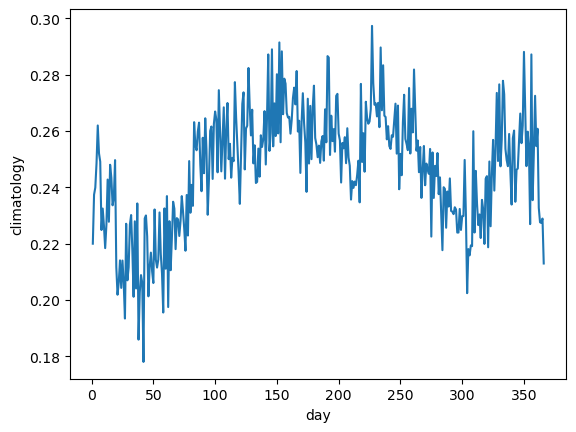

In [32]:
sns.lineplot(data=df_clim_reproduced, x='day', y='climatology')

In [33]:
area_id = 43

In [35]:
import requests

In [36]:
API_URL = "https://api.suyana.io/drought-bolivia/time-series"
API_KEY = "93a52c7a17676ed586c058e9f5315c9d66b256affd6d955897c7653d71d7fc08"
headers = {
    "Authorization": f"Bearer {API_KEY}"
}
params = {
    "area": area_id,  # Climatic area identifier
    "format": "json"  # Output format (optional, default is csv)
}
response = requests.get(API_URL, headers=headers, params=params)
df = pd.json_normalize(response.json())
#df["Time"] = pd.to_datetime(df["Time"])

In [43]:
df.set_index('Time', inplace=True)
ds_api = df.to_xarray()
ds_api

<xarray.Dataset> Size: 458kB
Dimensions:             (Time: 8175)
Coordinates:
  * Time                (Time) object 65kB '2002-06-16' ... '2024-10-31'
Data variables:
    Anomaly             (Time) float64 65kB 0.05077 0.05023 ... 0.006841
    Climatology         (Time) float64 65kB 0.2726 0.2731 ... 0.2303 0.2304
    Crop Cycle          (Time) float64 65kB nan nan nan nan ... nan nan nan nan
    Index               (Time) float64 65kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Negative Anomaly    (Time) float64 65kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Soil Water Content  (Time) float64 65kB 0.3233 0.3233 ... 0.2373 0.2373

In [48]:
ds.swc_adjusted.values[:15]

array([       nan, 0.32332862,        nan, 0.30934712, 0.27631665,
              nan, 0.29781393,        nan, 0.25909793,        nan,
       0.22961371, 0.21261863, 0.23339608,        nan,        nan])

In [51]:
ds.time.values[:15]

array(['2002-06-15T00:00:00.000000000', '2002-06-16T00:00:00.000000000',
       '2002-06-17T00:00:00.000000000', '2002-06-18T00:00:00.000000000',
       '2002-06-19T00:00:00.000000000', '2002-06-20T00:00:00.000000000',
       '2002-06-21T00:00:00.000000000', '2002-06-22T00:00:00.000000000',
       '2002-06-23T00:00:00.000000000', '2002-06-24T00:00:00.000000000',
       '2002-06-25T00:00:00.000000000', '2002-06-26T00:00:00.000000000',
       '2002-06-27T00:00:00.000000000', '2002-06-28T00:00:00.000000000',
       '2002-06-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [50]:
ds_api['Time'].values[:15]

array(['2002-06-16', '2002-06-17', '2002-06-18', '2002-06-19',
       '2002-06-20', '2002-06-21', '2002-06-22', '2002-06-23',
       '2002-06-24', '2002-06-25', '2002-06-26', '2002-06-27',
       '2002-06-28', '2002-06-29', '2002-06-30'], dtype=object)

In [49]:
ds_api['Soil Water Content'].values[:15]

array([0.32332862, 0.32332862, 0.31633787, 0.30299746, 0.30299746,
       0.30170158, 0.30170158, 0.29318085, 0.29318085, 0.28258633,
       0.27259094, 0.26769158, 0.26769158, 0.26769158, 0.26522833])

In [135]:
ds_treated = xr.open_dataset(gp + 'projects/suyana/data/capacity/canton_processed_43.nc')

In [61]:
df_treated = ds_treated.sel(time='2002-06-17').to_dataframe().reset_index()

In [64]:
df_treated.shape

(1800, 6)

In [63]:
df_treated.swc_adjusted.isna().sum()

1800

In [136]:
ds_2002 = xr.open_dataset(gp + 'suyana/drought/swc/raw/canton_209/canton_209_2.nc')

In [143]:
ds_2002

<xarray.Dataset> Size: 71MB
Dimensions:  (lon: 36, lat: 55, time: 4486)
Coordinates:
  * lon      (lon) float64 288B -63.36 -63.36 -63.35 ... -63.07 -63.06 -63.05
  * lat      (lat) float64 440B -16.68 -16.69 -16.7 ... -17.15 -17.16 -17.17
  * time     (time) datetime64[ns] 36kB 2012-07-25 2012-07-26 ... 2024-11-04
Data variables:
    swc      (time, lat, lon) float64 71MB 0.347 0.346 0.344 ... nan nan nan

In [138]:
df_treated = ds_2002.to_dataframe().reset_index()

In [155]:
df_nans = df_treated.groupby(['lon', 'lat'])["swc"].agg(lambda x: x.isna().sum()).reset_index(name = 'nans')

In [150]:
len(ds_2002.time)

4486

In [157]:
df_nans.sort_values(by=['nans'], ascending=False)

,lon,lat,nans
1943,-63.049550,-17.004505,4486
1979,-63.049550,-16.680180,4486
0,-63.364865,-17.166667,4486
1,-63.364865,-17.157658,4486
2,-63.364865,-17.148649,4486
...,...,...,...
93,-63.355856,-16.824324,1440
51,-63.364865,-16.707207,1440
53,-63.364865,-16.689189,1440
54,-63.364865,-16.680180,1440


# Counting nans in files

In [128]:
import os
path = gp+"/suyana/drought/swc/raw/"
folders = os.listdir(path)
folders = [f for f in folders if f.startswith("canton")]
folders

['canton_125',
 'canton_78',
 'canton_215',
 'canton_198',
 'canton_128',
 'canton_106',
 'canton_70',
 'canton_169',
 'canton_45',
 'canton_53',
 'canton_85',
 'canton_104',
 'canton_167',
 'canton_162',
 'canton_189',
 'canton_81',
 'canton_56',
 'canton_82',
 'canton_43',
 'canton_49',
 'canton_190',
 'canton_191',
 'canton_168',
 'canton_218',
 'canton_122',
 'canton_55',
 'canton_107',
 'canton_173',
 'canton_170',
 'canton_214',
 'canton_80',
 'canton_172',
 'canton_212',
 'canton_83',
 'canton_192',
 'canton_171',
 'canton_57',
 'canton_165',
 'canton_220',
 'canton_164',
 'canton_163',
 'canton_202',
 'canton_208',
 'canton_209',
 'canton_77',
 'canton_129',
 'canton_127',
 'canton_211',
 'canton_84',
 'canton_199',
 'canton_121',
 'canton_86',
 'canton_126',
 'canton_54',
 'canton_72',
 'canton_207',
 'canton_210',
 'canton_51',
 'canton_79',
 'canton_237',
 'canton_158',
 'canton_124',
 'canton_166',
 'canton_120',
 'canton_105',
 'canton_87',
 'canton_50',
 'canton_52',
 'ca

In [160]:
time_steps = len(ds.time)
type(time_steps)

int

In [166]:
df_report  = pd.DataFrame()
for folder in folders:
    print(f"{folder}")
    local_path = path + folder + '/'
    files = sorted(os.listdir(local_path))
    for i in range(len(files)):
        ds = xr.open_dataset(local_path + files[i])
        time_steps = len(ds.time)
        df = ds.to_dataframe().reset_index()
        df_nans = df.groupby(['lon', 'lat'])["swc"].agg(lambda x: x.isna().sum()).reset_index(name = 'nans')
        df_nans['flagPixelWithNan'] = np.where(df_nans['nans']>0, 1, 0)
        df_nans['propNans'] = df_nans['nans']/time_steps
        df_nans['flagValidPixel'] = np.where(df_nans['propNans']<1, 1, 0)
        df_nans['propNansValidPixel'] = np.where(df_nans['flagValidPixel']==1, df_nans['propNans'], np.nan)
        df_nans['id'] = files[i]
        df_nans = df_nans.groupby('id').agg(
            pixels = ('lon', 'count'),
            pixelsWithNans = ('flagPixelWithNan', 'sum'),
            validPixels = ('flagValidPixel', 'sum'),
            meanPropNansValidPixels = ('propNansValidPixel', 'mean')
        ).reset_index()

        df_report = pd.concat([df_report, df_nans], axis=0)


canton_125
canton_78
canton_215
canton_198
canton_128
canton_106
canton_70
canton_169
canton_45
canton_53
canton_85
canton_104
canton_167
canton_162
canton_189
canton_81
canton_56
canton_82
canton_43
canton_49
canton_190
canton_191
canton_168
canton_218
canton_122
canton_55
canton_107
canton_173
canton_170
canton_214
canton_80
canton_172
canton_212
canton_83
canton_192
canton_171
canton_57
canton_165
canton_220
canton_164
canton_163
canton_202
canton_208
canton_209
canton_77
canton_129
canton_127
canton_211
canton_84
canton_199
canton_121
canton_86
canton_126
canton_54
canton_72
canton_207
canton_210
canton_51
canton_79
canton_237
canton_158
canton_124
canton_166
canton_120
canton_105
canton_87
canton_50
canton_52
canton_195
canton_196
canton_194


In [169]:
df_report.to_csv(gp + 'projects/suyana/data/capacity/reporte_nans.csv', index=False)

In [180]:
df_report.iloc[120:140,:]

,id,pixels,pixelsWithNans,validPixels,meanPropNansValidPixels
0,canton_158_2.nc,1782,1782,1513,0.335054
0,canton_124_1.nc,24,24,14,0.383755
0,canton_124_2.nc,24,24,14,0.367875
0,canton_166_1.nc,1760,1760,1405,0.446082
0,canton_166_2.nc,1760,1760,1405,0.323879
0,canton_120_1.nc,2394,2394,933,0.392634
0,canton_120_2.nc,2394,2394,933,0.363337
0,canton_105_1.nc,285,285,239,0.383925
0,canton_105_2.nc,285,285,239,0.369426
0,canton_87_1.nc,1443,1443,723,0.411160


In [181]:
df_report.meanPropNansValidPixels.mean()

0.378204168510445